In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt



In [54]:
import sys

gdrive_project_root = '../' 

if 'google.colab' in sys.modules:
    from google.colab import drive
    # define project root / change to match your path
    gdrive_project_root = "drive/MyDrive/01-Education/03-PhD/2021/Courses/HCI/hci_code/"
    drive.mount('/content/drive', force_remount=True)  

In [55]:
# load gbm data with gene columns
raw = pd.read_csv(gdrive_project_root + '/data/raw/combined_study_clinical_data_gbm_filtered_nas_new_with_gene_details_without_ns.tsv.csv', delimiter='	')
print(raw['Oncotree Code'].unique())
print(raw.shape)
#raw.drop(raw.index[raw['Oncotree Code'] == "MNET"], inplace=True)
#print(raw.shape)
raw.drop(raw.index[raw['Oncotree Code'] == "ASTR"], inplace=True)
print(raw.shape)
raw.drop(raw.index[raw['Oncotree Code'] == "AODG"], inplace=True)
print(raw.shape)
raw.drop(raw.index[raw['Oncotree Code'] == "AOAST"], inplace=True)
print(raw.shape)
raw.drop(raw.index[raw['Oncotree Code'] == "OAST"], inplace=True)
print(raw.shape)
# remove columns where majority of values is Nan or Zero
raw.drop_duplicates()
print(raw.shape)
print(raw['Oncotree Code'].unique())

['GBM' 'ODG' 'AASTR' 'AODG' 'OAST' 'AOAST' 'ASTR']
(1541, 263)
(1489, 263)
(1424, 263)
(1376, 263)
(1285, 263)
(1285, 263)
['GBM' 'ODG' 'AASTR']


In [56]:
print(raw.columns) # list(raw.columns) # for complete list

Index(['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type Detailed',
       'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)',
       'Overall Survival Status', 'Number of Samples Per Patient',
       'Sample Type',
       ...
       'DYSF', 'IRS2', 'FCGBP', 'ADAMTS2', 'RALY', 'RBM23', 'RPTOR', 'DOCK5',
       'PRRC2B', 'AQP7P1'],
      dtype='object', length=263)


In [57]:
import math

# Class for preprocessing data for better suitability to classification
class DataPreprocessor:

  @staticmethod
  def isNanOrZero(value):
      if isinstance(value, str):
          if "nan" in value.lower() or "0" in value:
              return True
      elif isinstance(value, float):
          if math.isnan(value) or value == 0.0:
              return True
      elif isinstance(value, int):
          if value == 0:
              return True
      return False

  @staticmethod
  def deleteRowIfColumnIsNan(data_frame: pd.DataFrame, column_name: str):
        for index, row in data_frame.iterrows():
            if not (row[column_name] > 0):
                data_frame.drop(index, inplace=True)
        return data_frame

  @staticmethod
  def countMutations(data_frame: pd.DataFrame):
      for column_name in data_frame:
          if column_name not in ['Oncotree Code', 'Mutation Count', 'Overall Survival (Months)', 'Overall Survival Status', 'Sex', 'Somatic Status', 'Diagnosis Age']:
#               data_frame[column_name] = data_frame[column_name].astype(str).str.split(' ').str.len()
              data_frame[column_name] = data_frame[column_name].apply(lambda x: 0 if x == 'WT' else len(x.split(' ')))
      return data_frame

  @staticmethod
  def replaceNanValuesWithMedian(data_frame: pd.DataFrame):
      return data_frame.fillna(data_frame.median())

# define new data_frame with only interesting selecting of raw data
df = raw[['Oncotree Code', 'Mutation Count', 'Overall Survival (Months)', 'Overall Survival Status', 'Sex', 'Somatic Status', 'Diagnosis Age', 'TP53', 'TERT', 'IDH1', 'ATRX', 'PABPC3', 'PTEN', 'MUC16', 'EGFR', 'CIC', 'NF1', 'MUC6', 'TAS2R46', 'TTN', 'MUC4', 'PIK3CA', 'MUC3A', 'NOTCH1', 'PIK3R1', 'TRBV7-7', 'SPRY3',  'KMT2D', 'MUC12', 'CNN2', 'RB1', 'GXYLT1', 'MST1P2', 'HLA-DRB5', 'SMARCA4', 'ARID1A', 'KMT2C', 'PDGFRA', 'FUBP1', 'FAT1', 'MUC17', 'MUC5B', 'SETD2', 'TRBV10-1', 'MUC2', 'CREBBP', 'ARID1B', 'UBXN11', 
         'SPEN', 'GOLGA6L2', 'ATM', 'PTPN11', 'STAG2', 'MAP3K1', 'NOTCH2', 'NOTCH4', 'FLG', 'MSH6', 'KMT2A', 'ZFHX3', 'MED12', 'BCOR', 'PCLO', 'BAGE2', 'ARID2', 'MGA', 'GRIN2A', 'NOTCH3', 'IGHJ6', 'OBSCN', 'BRCA2', 'EP300', 'HLA-DRB6','POLE', 'NSD1', 'HMCN1', 'HLA-DRB1', 'RYR2', 'APC', 'AHNAK2', 'FRG2B', 'PLIN4', 'FLT4', 'NEB', 'TRBV7-1', 'ATR', 'PIK3CG', 'NCOR1', 'NCOA3', 'PTPRT', 'TEKT4', 'MET', 'APOB', 'TSC2', 'TET2', 'CRIPAK', 'ZNF717', 'KDR', 'LRP2', 'USH2A', 'TRBV5-4', 'ANKRD11', 'CARD11', 'ASXL1', 
         'EPHA3', 'RELN', 'SYNE1', 'PBRM1', 'TRPM3', 'ADGRV1', 'ASPM', 'BRCA1', 'FANCA', 'IDH2', 'PIK3C2G', 'ROS1', 'DOT1L', 'ALK', 'BRAF', 'FLT1', 'MTOR', 'IRS1', 'KAZN', 'ANKRD30A', 'FAT2', 'HLA-DQA2', 'PLCG2', 'PTPRS', 'KDM5A', 'SPTA1', 'ZNF208', 'TMLHE', 'NHEJ1', 'LRP1B', 'SLC25A5', 'COL6A3', 'DNMT3A', 'ERBB4', 'PTPRD', 'DNAH2', 'DSPP', 'TSC1', 'FBN3', 'AR', 'EPHA5', 'KCNJ12', 'WNK1', 'AMER1', 'CACNA1A', 'DNAH5', 'FGFR3', 'PKHD1', 'RYR1', 'TCHH', 'AXL', 'MDC1', 'SF3B1', 'RIN3', 'SVEP1', 'COL18A1', 
         'FAT3', 'RICTOR', 'CDKN2C', 'DNMT1', 'IGF1R', 'MSH2', 'PRKDC', 'KDM5C', 'URI1', 'CDON', 'FRAS1', 'PARP1', 'INSR', 'MAP3K4', 'PLEC', 'PTCH1', 'DNAH11', 'TRBV5-6', 'ASXL2', 'ABCA13', 'CD163L1', 'DDX12P', 'NBPF10', 'PRDM1', 'CSF1R', 'DNAH9', 'GLI1', 'JAK3', 'PMS2', 'RYR3', 'ATXN1', 'ZNF141', 'TRRAP', 'MAGI1', 'DICER1', 'IGHV1-3', 'SPTBN5', 'EFCAB7', 'AXDND1', 'SLC9C1', 'LINC00955', 'PPIAL4G', 'ANK3', 'DACH1', 'ERBB2', 'GNAQ', 'JAK1', 'MST1R', 'KDM6A', 'ALMS1', 'MYH15', 'PDZRN3', 'BRD4', 'TRBV5-5', 
         'TMPRSS13', 'CDKN2A', 'ATN1', 'FGFR1', 'GNAS', 'KRT18', 'LAMA3', 'PGR', 'SOS2', 'VIL1', 'DCHS1', 'KMT2B', 'CD226', 'MPRIP', 'DNAH3', 'CEP290', 'KRTAP4-6', 'CSMD3', 'PRAG1', 'PKD1L1', 'CNOT6L', 'BCL6', 'ERBB3', 'HGF', 'KIT', 'MLH1', 'NRAP', 'POU4F2', 'SDHA', 'DYSF', 'IRS2', 'FCGBP', 'ADAMTS2', 'RALY', 'RBM23', 'RPTOR', 'DOCK5', 'PRRC2B', 'AQP7P1'
         ]].copy(deep=True)

# replace nan values with mean of column
#df = DataPreprocessor.replaceNanValuesWithMedian(data_frame = df)
print(df.shape)
df = DataPreprocessor.countMutations(data_frame = df)
print(df.shape)
df.dropna(inplace=True) # remove nas
print(df.shape)

# since classifier cannot work with string but int/float, further encode data:

#print(list(df['Overall Survival Status'].unique()))
df.loc[df['Overall Survival Status']=="1:DECEASED",'Overall Survival Status']=1
df.loc[df['Overall Survival Status']=="0:LIVING",'Overall Survival Status']=0
print(list(df['Overall Survival Status'].unique()))

#print(list(df['Sex'].unique()))
df.loc[df['Sex']=="Female",'Sex']=1
df.loc[df['Sex']=="Male",'Sex']=0
print(list(df['Sex'].unique()))

#print(list(df['Somatic Status'].unique()))
df.loc[df['Somatic Status']=="Matched",'Somatic Status']=1
df.loc[df['Somatic Status']=="Unmatched",'Somatic Status']=0
print(list(df['Somatic Status'].unique()))

print(list(df['TP53'].unique()))
print(list(df['TERT'].unique()))
print(list(df['IDH1'].unique()))

#print(list(df['Oncotree Code'].sort_values().unique()))
#['AASTR', 'AOAST', 'AODG', 'ASTR', 'GBM', 'OAST', 'ODG']
df.loc[df['Oncotree Code']=="GBM",'Oncotree Code']=1
df.loc[df['Oncotree Code']=="AASTR",'Oncotree Code']=2
df.loc[df['Oncotree Code']=="ODG",'Oncotree Code']=3
df.loc[df['Oncotree Code']=="ASTR",'Oncotree Code']=4
df.loc[df['Oncotree Code']=="OAST",'Oncotree Code']=5
df.loc[df['Oncotree Code']=="AODG",'Oncotree Code']=6
df.loc[df['Oncotree Code']=="AOAST",'Oncotree Code']=7
print(list(df['Oncotree Code'].unique()))


(1285, 253)
(1285, 253)
(1276, 253)
[1, 0]
[0, 1]
[1, 0]
[0, 1, 2, 3]
[0, 1, 2, 3, 5]
[0, 1, 2]
[1, 3, 2]


In [58]:
# outcommented: targeting survival
# now using as target the first three most glioma subtypes: ['GBM' 'ODG' 'AASTR']

#X_cols = ['Oncotree Code', 'Mutation Count', 'Overall Survival (Months)', 'Sex', 'Somatic Status', 'Diagnosis Age', 'TP53', 'TERT', 'IDH1', 'ATRX', 'PABPC3', 'PTEN', 'MUC16', 'EGFR', 'CIC', 'NF1', 'MUC6', 'TAS2R46', 'TTN', 'MUC4', 'PIK3CA', 'MUC3A', 'NOTCH1', 'PIK3R1', 'TRBV7-7', 'SPRY3',
X_cols = ['Overall Survival Status', 'Mutation Count', 'Overall Survival (Months)', 'Sex', 'Somatic Status', 'Diagnosis Age', 'TP53', 'TERT', 'IDH1', 'ATRX', 'PABPC3', 'PTEN', 'MUC16', 'EGFR', 'CIC', 'NF1', 'MUC6', 'TAS2R46', 'TTN', 'MUC4', 'PIK3CA', 'MUC3A', 'NOTCH1', 'PIK3R1', 'TRBV7-7', 'SPRY3',
 'KMT2D', 'MUC12', 'CNN2', 'RB1', 'GXYLT1', 'MST1P2', 'HLA-DRB5', 'SMARCA4', 'ARID1A', 'KMT2C', 'PDGFRA', 'FUBP1', 'FAT1', 'MUC17', 'MUC5B', 'SETD2', 'TRBV10-1', 'MUC2', 'CREBBP', 'ARID1B', 'UBXN11', 'SPEN', 'GOLGA6L2', 'ATM', 'PTPN11', 'STAG2', 'MAP3K1', 'NOTCH2', 'NOTCH4', 'FLG', 'MSH6', 'KMT2A', 'ZFHX3', 'MED12', 'BCOR', 'PCLO', 'BAGE2', 'ARID2', 'MGA', 'GRIN2A', 'NOTCH3', 'IGHJ6', 'OBSCN', 'BRCA2', 'EP300', 'HLA-DRB6','POLE', 'NSD1', 'HMCN1', 'HLA-DRB1', 'RYR2', 'APC', 'AHNAK2', 'FRG2B', 'PLIN4', 'FLT4',
 'NEB', 'TRBV7-1', 'ATR', 'PIK3CG', 'NCOR1', 'NCOA3', 'PTPRT', 'TEKT4', 'MET', 'APOB', 'TSC2', 'TET2', 'CRIPAK', 'ZNF717', 'KDR', 'LRP2', 'USH2A', 'TRBV5-4', 'ANKRD11', 'CARD11', 'ASXL1', 'EPHA3', 'RELN', 'SYNE1', 'PBRM1', 'TRPM3', 'ADGRV1', 'ASPM', 'BRCA1', 'FANCA', 'IDH2', 'PIK3C2G', 'ROS1', 'DOT1L', 'ALK', 'BRAF', 'FLT1', 'MTOR', 'IRS1', 'KAZN', 'ANKRD30A', 'FAT2', 'HLA-DQA2', 'PLCG2', 'PTPRS', 'KDM5A', 'SPTA1', 'ZNF208', 'TMLHE', 'NHEJ1', 'LRP1B', 'SLC25A5', 'COL6A3', 'DNMT3A', 'ERBB4', 'PTPRD', 'DNAH2',
 'DSPP', 'TSC1', 'FBN3', 'AR', 'EPHA5', 'KCNJ12', 'WNK1', 'AMER1', 'CACNA1A', 'DNAH5', 'FGFR3', 'PKHD1', 'RYR1', 'TCHH', 'AXL', 'MDC1', 'SF3B1', 'RIN3', 'SVEP1', 'COL18A1', 'FAT3', 'RICTOR', 'CDKN2C', 'DNMT1', 'IGF1R', 'MSH2', 'PRKDC', 'KDM5C', 'URI1', 'CDON', 'FRAS1', 'PARP1', 'INSR', 'MAP3K4', 'PLEC', 'PTCH1', 'DNAH11', 'TRBV5-6', 'ASXL2', 'ABCA13', 'CD163L1', 'DDX12P', 'NBPF10', 'PRDM1', 'CSF1R', 'DNAH9', 'GLI1', 'JAK3', 'PMS2', 'RYR3', 'ATXN1', 'ZNF141', 'TRRAP', 'MAGI1', 'DICER1', 'IGHV1-3', 'SPTBN5', 
 'EFCAB7', 'AXDND1', 'SLC9C1', 'LINC00955', 'PPIAL4G', 'ANK3', 'DACH1', 'ERBB2', 'GNAQ', 'JAK1', 'MST1R', 'KDM6A', 'ALMS1', 'MYH15', 'PDZRN3', 'BRD4', 'TRBV5-5', 'TMPRSS13', 'CDKN2A', 'ATN1', 'FGFR1', 'GNAS', 'KRT18', 'LAMA3', 'PGR', 'SOS2', 'VIL1', 'DCHS1', 'KMT2B', 'CD226', 'MPRIP', 'DNAH3', 'CEP290', 'KRTAP4-6', 'CSMD3', 'PRAG1', 'PKD1L1', 'CNOT6L', 'BCL6', 'ERBB3', 'HGF', 'KIT', 'MLH1', 'NRAP', 'POU4F2', 'SDHA', 'DYSF', 'IRS2', 'FCGBP', 'ADAMTS2', 'RALY', 'RBM23', 'RPTOR', 'DOCK5', 'PRRC2B', 'AQP7P1']
#y_col = ['Overall Survival Status']
y_col = ['Oncotree Code']

X = df[X_cols]
y = df[y_col]
print(len(X.columns))
print(len(y))

252
1276


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
#y_train.hist()
#y_test.hist()
#X_train.hist()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1020, 252) (256, 252) (1020, 1) (256, 1)


In [60]:
#print(X_train.value_counts())
#print(X_test.value_counts())
print(y_train['Oncotree Code'].value_counts())
print(y_test['Oncotree Code'].value_counts())

1    695
2    189
3    136
Name: Oncotree Code, dtype: int64
1    177
2     45
3     34
Name: Oncotree Code, dtype: int64


/home/abyss/anaconda3/envs/hci2/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           1       0.88      0.95      0.91       177
           2       0.67      0.49      0.56        45
           3       0.87      0.79      0.83        34

    accuracy                           0.85       256
   macro avg       0.80      0.74      0.77       256
weighted avg       0.84      0.85      0.84       256



/home/abyss/anaconda3/envs/hci2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


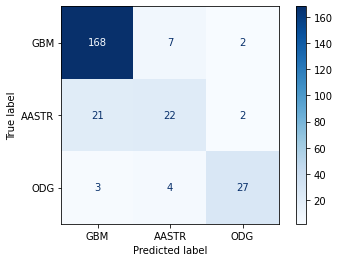

In [61]:
clf = LogisticRegression().fit(X_train, y_train) #.values.ravel()
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))
plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, display_labels=["GBM", "AASTR", "ODG"], values_format = '')

              precision    recall  f1-score   support

           1       0.85      0.96      0.90       177
           2       0.70      0.42      0.53        45
           3       0.90      0.79      0.84        34

    accuracy                           0.84       256
   macro avg       0.82      0.73      0.76       256
weighted avg       0.83      0.84      0.83       256



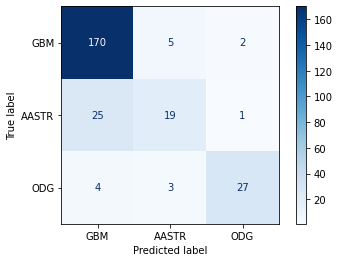

In [62]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train.values.ravel()) 
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))
plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, display_labels=["GBM", "AASTR", "ODG"], values_format = '')

In [63]:
for col in X.columns:
    print(X[col].value_counts())

0    655
1    621
Name: Overall Survival Status, dtype: int64
4.0      158
3.0      150
5.0      140
6.0       85
2.0       80
        ... 
714.0      1
696.0      1
698.0      1
135.0      1
109.0      1
Name: Mutation Count, Length: 154, dtype: int64
11.00     11
10.80      9
15.60      8
5.40       7
18.00      6
          ..
120.00     1
6.77       1
2.99       1
3.55       1
41.50      1
Name: Overall Survival (Months), Length: 736, dtype: int64
0    781
1    495
Name: Sex, dtype: int64
1    1123
0     153
Name: Somatic Status, dtype: int64
56.0    33
54.0    32
51.0    31
38.0    30
53.0    29
        ..
49.6     1
45.4     1
60.8     1
78.8     1
50.4     1
Name: Diagnosis Age, Length: 242, dtype: int64
0    828
1    349
2     95
3      4
Name: TP53, dtype: int64
0    662
1    601
2     10
3      2
5      1
Name: TERT, dtype: int64
0    940
1    333
2      3
Name: IDH1, dtype: int64
0    1070
1     188
2      15
7       1
4       1
3       1
Name: ATRX, dtype: int64
1     803
0 

# Exporting the model and data

In [64]:
import joblib

joblib.dump(clf, gdrive_project_root+'models/CLF_3classes_GBM-AASTR-ODG_RandomForest_100estimators_42_random_state.pkl', compress=9)

['../models/CLF_3classes_GBM-AASTR-ODG_RandomForest_100estimators_42_random_state.pkl']

In [65]:
X.to_csv(gdrive_project_root + 'data/processed/2nd_dataset/3_cls_model_input/X_3cls.csv', index=False)
y.to_csv(gdrive_project_root + 'data/processed/2nd_dataset/3_cls_model_input/y_3cls.csv', index=False)
X_train.to_csv(gdrive_project_root + 'data/processed/2nd_dataset/3_cls_model_input/X_train_3cls.csv', index=False)
X_test.to_csv(gdrive_project_root + 'data/processed/2nd_dataset/3_cls_model_input/X_test_3cls.csv', index=False)
y_train.to_csv(gdrive_project_root + 'data/processed/2nd_dataset/3_cls_model_input/y_train_3cls.csv', index=False)
y_test.to_csv(gdrive_project_root + 'data/processed/2nd_dataset/3_cls_model_input/y_test_3cls.csv', index=False)